In [1]:
import os

# Set the environment variable before importing torch
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import torch

# Now, you can use PyTorch as usual

import time
import copy
import pickle
from barbar import Bar
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2
%matplotlib inline
import torch.nn.functional as F
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torchsummary import summary

from tqdm import tqdm
from pathlib import Path
import gc
RANDOMSTATE = 0

In [2]:
import pandas as pd
from pathlib import Path

# Specify the relative or absolute path to the SGY file
file_path = Path('issap20_Pp.sgy')

# Get the absolute path
absolute_path = file_path.resolve()

# Create a dictionary to represent the data you want in the DataFrame
data = {
    'file_name': [file_path.name],  # Just the file name (without directory)
    'absolute_path': [absolute_path],  # Full absolute path
    'directory': [absolute_path.parent],  # Parent directory of the file
    'extension': [file_path.suffix]  # File extension (e.g., .sgy)
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)


        file_name                                   absolute_path  \
0  issap20_Pp.sgy  C:\Users\Intern\Untitled Folder\issap20_Pp.sgy   

                         directory extension  
0  C:\Users\Intern\Untitled Folder      .sgy  


In [3]:
import segyio
import numpy as np

filename_pp = r"C:\Users\Intern\Untitled Folder\issap20_Pp.sgy"

# Note: the xline header info location is at segyio.su.cdpx [181]
def segy2numpy(filename: str) -> np.array:
    with segyio.open(filename, xline=181) as segyfile:
        return segyio.tools.cube(segyfile)

seismic = segy2numpy(filename_pp)


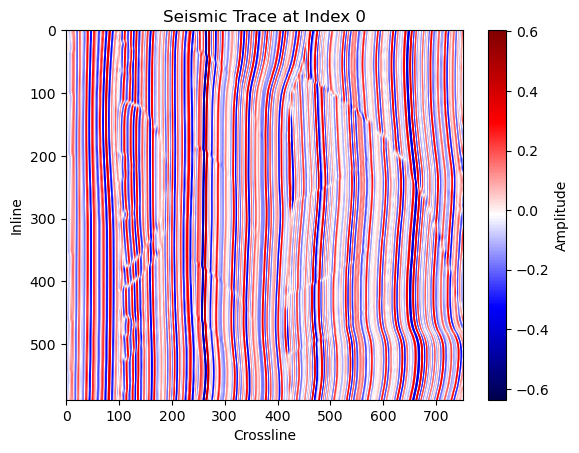

In [4]:
import matplotlib.pyplot as plt

# Display a slice from the 3D array (e.g., a single trace or time slice)
# For example, plot the first trace (index 0) across all depths.
plt.imshow(seismic[0, :, :], cmap='seismic', aspect='auto')
plt.colorbar(label='Amplitude')
plt.title('Seismic Trace at Index 0')
plt.xlabel('Crossline')
plt.ylabel('Inline')
plt.show()


In [5]:
import zipfile
import os

# Path to the ZIP archive and folder where it will be extracted
zip_file_path = r"C:\Users\Intern\Downloads\archive (4).zip"  # Adjust this if the archive has a different name
extracted_folder = r"C:\Users\Intern\Downloads\extracted"

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

# Print the extracted files to verify
extracted_files = os.listdir(extracted_folder)
print(f"Extracted files: {extracted_files}")


Extracted files: ['annotations', 'images', 'instances_default.json']


In [6]:
from skimage.io import imread
import os

images_dir = os.path.join(extracted_folder, 'images')  # Make sure the folder exists
image_list = sorted(os.listdir(images_dir))  # List of image file names
images = [imread(os.path.join(images_dir, img_path)) for img_path in image_list]


In [7]:
import json
import os
annotations_path = os.path.join(extracted_folder, 'instances_default.json')
with open(annotations_path, 'r', encoding='utf-8') as f:
    annotations = json.load(f)

print("Keys in annotations:", annotations.keys())


Keys in annotations: dict_keys(['licenses', 'info', 'categories', 'images', 'annotations'])


Dataset contains 512 images


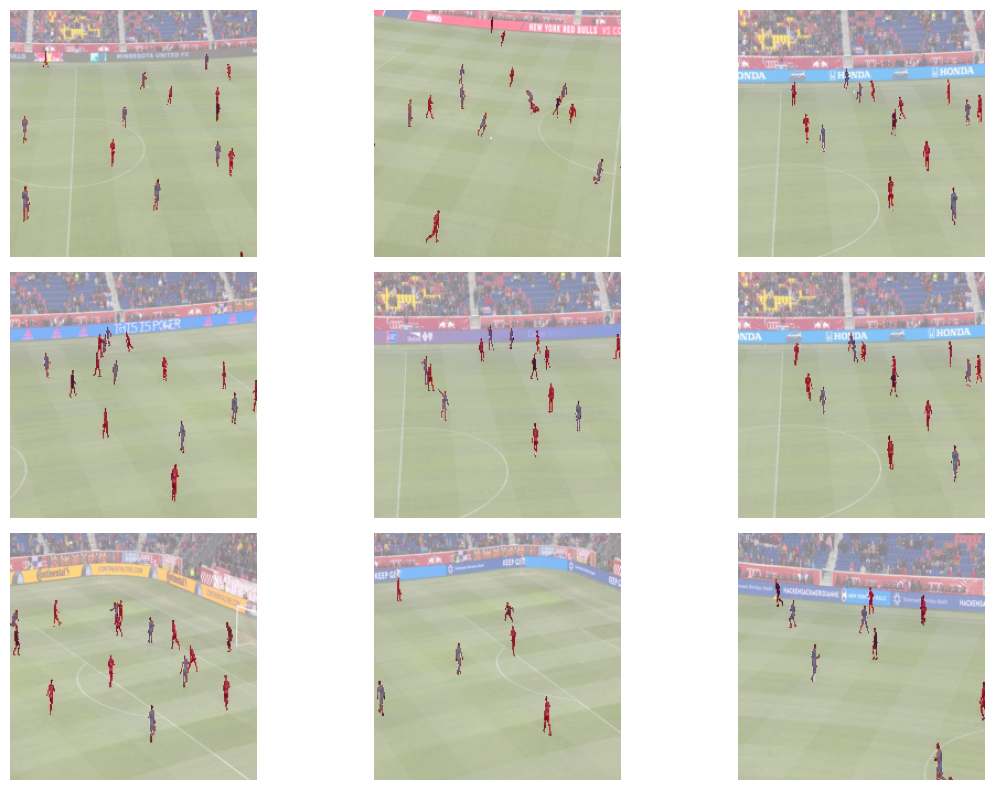

Masks saved as masks.npy


In [8]:
import os
import json
import random
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import resize
from imantics import Polygons

# Set image size
image_size = 224
input_image_size = (1920, 1080)

# Define paths
images_dir = r"C:\Users\Intern\Downloads\extracted_images\images"  # Change to your actual directory
annotation_file = r"C:\Users\Intern\Downloads\extracted_images\annotations\instances_default.json"

# Load annotation file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# List all images in the directory
images_listdir = os.listdir(images_dir)
print(f"Dataset contains {len(images_listdir)} images")

# Define transformation pipeline
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize to 512x512
    transforms.ToTensor(),  # Convert to PyTorch tensor
])

# Load images into a tensor array
images = torch.zeros((len(images_listdir), 3, image_size, image_size), dtype=torch.float32)

# Create mapping from image ID to filename
id_to_images = {img["id"]: img["file_name"] for img in annotations["images"]}

# Load and transform images
for image_id, image_filename in id_to_images.items():
    img_path = os.path.join(images_dir, image_filename)
    if os.path.exists(img_path):  # Ensure file exists before loading
        img = Image.open(img_path).convert("RGB")  # Open image
        img = transform(img)  # Apply transformations
        images[image_id - 1] = img  # Store in tensor

# Initialize masks as boolean tensor
masks = torch.zeros((len(images_listdir), 1, image_size, image_size), dtype=torch.bool)

# Process annotations to create masks
for annotation in annotations["annotations"]:
    image_id = annotation["image_id"]
    segmentation = annotation["segmentation"]

    # Create a binary mask from polygon segmentation
    cur_mask = Polygons(segmentation).mask(*input_image_size).array
    cur_mask = resize(cur_mask, (image_size, image_size), mode='constant', preserve_range=True)

    # Convert mask to boolean tensor and expand dimensions
    cur_mask = torch.tensor(cur_mask > 0, dtype=torch.bool).unsqueeze(0)

    # Assign mask to corresponding image index
    mask_index = image_id - 1
    masks[mask_index] = masks[mask_index] | cur_mask  # Bitwise OR now works correctly

# Select random images for visualization
random_indices = random.sample(range(len(images_listdir)), 9)

# Set up visualization
rows, cols = 3, 3
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    if i < len(random_indices):
        idx = random_indices[i]

        # Convert image tensor to NumPy for visualization
        img_np = images[idx].permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)

        # Convert mask tensor to NumPy
        mask_np = masks[idx].squeeze(0).numpy()  # Remove channel dimension

        # Display image
        ax.imshow(img_np)
        ax.imshow(mask_np, alpha=0.5, cmap='Reds')  # Overlay mask with transparency
        ax.axis('off')  # Hide axes

plt.tight_layout()
plt.show()


# Save the masks after creation
np.save('masks.npy', masks.numpy())  # Convert to NumPy before saving
print('Masks saved as masks.npy')

In [9]:
import os

annotations_dir = r"C:\Users\Intern\Downloads\extracted_images"
print("Files in directory:", os.listdir(annotations_dir))


Files in directory: ['annotations', 'images']


In [10]:
dataset_code = r'''

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage.io import imread
import numpy as np
import os

class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_file, transform=None):
        self.images_dir = images_dir
        self.masks = np.load(masks_file)  # Assumes masks are stored in a numpy array
        self.image_paths = sorted(os.listdir(images_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.image_paths[idx])
        image = imread(image_path)
        mask = self.masks[idx]

        # Convert image and mask to tensors
        image = torch.tensor(image).permute(2, 0, 1).float() / 255.0  # Normalize image to [0,1]
        mask = torch.tensor(mask).unsqueeze(0).float()  # Add channel dimension for mask

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Define transformations (if any)
transform = transforms.Compose([
    transforms.ToTensor(),
    # You can add other transformations like random crop, flip, etc.
])

# Define the zip file and the extraction path
zip_file_path = r"C:\Users\Intern\Downloads\archive (4).zip"
extracted_folder = r"C:\Users\Intern\Downloads\extracted_images"

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

# Print the contents to ensure extraction
("Extracted files:", os.listdir(extracted_folder))

# Now, assuming the 'images' folder is inside the extracted folder
images_dir = os.path.join(extracted_folder, 'images')

# Check if the images folder exists
("Contents of images directory:", os.listdir(images_dir))

# Proceed with the DataLoader using the extracted folder path
train_dataset = SegmentationDataset(images_dir=images_dir, masks_file="masks.npy", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
'''

target_directory = r"C:\Users\Intern\Untitled Folder" 
# Specify the directory and file name
dataset_file_path = os.path.join(target_directory, 'dataset.py')

# Write the code to the dataset.py file
with open(dataset_file_path, 'w') as f:
    f.write(dataset_code)

print(f"dataset.py file created at: {dataset_file_path}")

dataset.py file created at: C:\Users\Intern\Untitled Folder\dataset.py


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Convolution Block
def conv_block(input_channel, output_channel, kernel_size=3, rate=1,padding=1):
    
    return nn.Sequential(
        nn.Conv2d(input_channel, output_channel, kernel_size, dilation=rate,stride=1,padding=padding),
        nn.BatchNorm2d(output_channel),
        nn.ReLU(inplace=True)
    )

class RSU_1(nn.Module):
    def __init__(self, input_channel, middle_channel, output_channel, num_layers):
        super(RSU_1, self).__init__()
        self.num_layers = num_layers
#         input_shape=(3, 224, 224)
#         self.x= (3, 224, 224)
        
        self.skip_connections = nn.ModuleList()

        
        # Initial convolution
        self.encoder = nn.ModuleList() 
        self.initial_conv = conv_block(input_channel,output_channel,kernel_size=3,rate =1,padding=1)
        self.encoder.append(self.initial_conv)
        
        self.conv1 = conv_block(output_channel,middle_channel,kernel_size=3,rate=1,padding=1)
        self.encoder.append(self.conv1)
        
        self.conv2 = nn.Sequential(
            nn.MaxPool2d(2,stride=2),
            conv_block(middle_channel,middle_channel,kernel_size=3,rate=1,padding=1),
        )
        self.encoder.append(self.conv2)
        
        self.conv3 = nn.Sequential(
            nn.MaxPool2d(2,stride=2),
            conv_block(middle_channel,middle_channel,kernel_size=3,rate=1,padding=1),
        )
        self.encoder.append(self.conv3)
        
        self.conv4 = nn.Sequential(
            nn.MaxPool2d(2,stride=2),
            conv_block(middle_channel,output_channel,kernel_size=3,rate=1,padding=1),
        )
        self.encoder.append(self.conv4)
        
        self.conv5 = nn.Sequential(
            nn.MaxPool2d(2,stride=2),
            conv_block(output_channel,output_channel,kernel_size=3,rate=1,padding=1),
        )
        self.encoder.append(self.conv5)
        
        self.dilation = conv_block(output_channel,output_channel,kernel_size=3,rate=2,padding=2)
        

        # Decoder layers
        self.decoder = nn.ModuleList()
        
        self.middle_conv = conv_block(output_channel,output_channel,kernel_size=3,rate=1)
        self.decoder.append(self.middle_conv)

        self.d1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            conv_block(output_channel*2,output_channel, kernel_size=3),
        )
        self.decoder.append(self.d1)
        
        self.d2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            conv_block(output_channel*2,middle_channel, kernel_size=3),
        )
        self.decoder.append(self.d2)
        
        self.d3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            conv_block(output_channel,middle_channel, kernel_size=3),
        )
        self.decoder.append(self.d3)
        
        self.d4 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            conv_block(output_channel,middle_channel, kernel_size=3),
        )
        self.decoder.append(self.d4)
        
       
        self.final_conv = conv_block(output_channel,output_channel,kernel_size = 3)
    def forward(self, x):
        
        skip_connections = []
        print(f'shape of x:{x.shape}')
        # Initial Convolution
        x = self.initial_conv(x)
        
        skip_connections.append(x)
        print(f'After initial_conv: {x.shape}')
        x = self.conv1(x)
        skip_connections.append(x)
        
        x = self.conv2(x)
        skip_connections.append(x)
        
        x = self.conv3(x)
        skip_connections.append(x)
        
        x = self.conv4(x)
        skip_connections.append(x)
        
        x = self.conv5(x)
        skip_connections.append(x)
        print(f'After 5th_conv: {x.shape}')

        # Bottleneck with Dilation
        x = self.dilation(x)
        print(f'After dilation: {x.shape}')
        
        x = self.middle_conv(x)
        print(f'After middle conv: {x.shape}')
        
        # Reverse skip connections for decoding
        skip_connections = skip_connections[::-1]

        
        x = torch.cat((x, skip_connections[0]), dim=1)  # Concatenation doubles channels
        print(f'After first concatenation: {x.shape}')
        
        x = self.d1(x)
        x = torch.cat((x, skip_connections[1]), dim=1)
        print(f'After second concatenation: {x.shape}')
        
        x = self.d2(x)
        x = torch.cat((x, skip_connections[2]), dim=1)
        
        x = self.d3(x)
        x = torch.cat((x, skip_connections[3]), dim=1)
        
        x = self.d4(x)
        x = torch.cat((x, skip_connections[4]), dim=1)
        
        x = self.final_conv(x)
        x = torch.add(x, skip_connections[-1])
        print(f'After final concatenation:{x.shape}')
        return x




In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Convolution Block
def conv_block(input_channel, output_channel, kernel_size=3, rate=1,padding=1):
    
    return nn.Sequential(
        nn.Conv2d(input_channel, output_channel, kernel_size, dilation=rate,stride=1,padding=padding),
        nn.BatchNorm2d(output_channel),
        nn.ReLU(inplace=True)
    )

class RSU_2(nn.Module):
    def __init__(self, input_channel, middle_channel, output_channel, num_layers):
        super(RSU_2, self).__init__()
        self.num_layers = num_layers
#         input_shape=(3, 224, 224)
#         self.x= (3, 224, 224)
        
        self.skip_connections = nn.ModuleList()

        # Initial convolution
        self.encoder = nn.ModuleList() 
        self.initial_conv = conv_block(input_channel,output_channel,kernel_size=3,rate =1,padding=1)
        self.encoder.append(self.initial_conv)
        
        self.conv1 = conv_block(output_channel,middle_channel,kernel_size=3,rate=1,padding=1)
        self.encoder.append(self.conv1)
        
        self.conv2 = nn.Sequential(
            nn.MaxPool2d(2,stride=2),
            conv_block(middle_channel,middle_channel,kernel_size=3,rate=1,padding=1),
        )
        self.encoder.append(self.conv2)
        
        self.conv3 = nn.Sequential(
            nn.MaxPool2d(2,stride=2),
            conv_block(middle_channel,output_channel,kernel_size=3,rate=1,padding=1),
        )
        self.encoder.append(self.conv3)
        
        self.conv4 = nn.Sequential(
            nn.MaxPool2d(2,stride=2),
            conv_block(output_channel,output_channel,kernel_size=3,rate=1,padding=1),
        )
        self.encoder.append(self.conv4)
        
        self.dilation = conv_block(output_channel,output_channel,kernel_size=3,rate=2,padding=2)
        

        # Decoder layers
        self.decoder = nn.ModuleList()
        
        self.middle_conv = conv_block(output_channel,output_channel,kernel_size=3,rate=1)
        self.decoder.append(self.middle_conv)

        self.d1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            conv_block(output_channel*2,output_channel, kernel_size=3),
        )
        self.decoder.append(self.d1)
        
        self.d2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            conv_block(output_channel*2,middle_channel, kernel_size=3),
        )
        self.decoder.append(self.d2)
        
        self.d3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            conv_block(output_channel,middle_channel, kernel_size=3),
        )
        self.decoder.append(self.d3)
       
        self.final_conv  = conv_block(output_channel,output_channel,kernel_size = 3)
    def forward(self, x):
        
        skip_connections = []
        print(f'shape of x:{x.shape}')
        # Initial Convolution
        x = self.initial_conv(x)
        
        skip_connections.append(x)
        print(f'After initial_conv: {x.shape}')
        x = self.conv1(x)
        skip_connections.append(x)
        
        x = self.conv2(x)
        skip_connections.append(x)
        
        x = self.conv3(x)
        skip_connections.append(x)
        
        x = self.conv4(x)
        skip_connections.append(x)
        

        # Bottleneck with Dilation
        x = self.dilation(x)
        print(f'After dilation: {x.shape}')
        
        x = self.middle_conv(x)
        print(f'After middle conv: {x.shape}')
        
        # Reverse skip connections for decoding
        skip_connections = skip_connections[::-1]
        
        x = torch.cat((x, skip_connections[0]), dim=1)  # Concatenation doubles channels
        print(f'After first concatenation: {x.shape}')
        
        x = self.d1(x)
        x = torch.cat((x, skip_connections[1]), dim=1)
        
        x = self.d2(x)
        x = torch.cat((x, skip_connections[2]), dim=1)
        
        x = self.d3(x)
        x = torch.cat((x, skip_connections[3]),dim=1)
        
        x = self.final_conv(x)
        print(f'shape of {x.shape}')
        x = torch.add(x,skip_connections[-1])
        print(f'After final concatenation:{x.shape}')
        return x

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Convolution Block
def conv_block(input_channel, output_channel, kernel_size=3, rate=1,padding=1):
    
    return nn.Sequential(
        nn.Conv2d(input_channel, output_channel, kernel_size, dilation=rate,stride=1,padding=padding),
        nn.BatchNorm2d(output_channel),
        nn.ReLU(inplace=True)
    )

class RSU_3(nn.Module):
    def __init__(self, input_channel, middle_channel, output_channel, num_layers):
        super(RSU_3, self).__init__()
        self.num_layers = num_layers
#         input_shape=(3, 224, 224)
#         self.x= (3, 224, 224)
        
        self.skip_connections = nn.ModuleList()

        # Initial convolution
        self.encoder = nn.ModuleList() 
        self.initial_conv = conv_block(input_channel,output_channel,kernel_size=3,rate =1,padding=1)
        self.encoder.append(self.initial_conv)
        
        self.conv1 = conv_block(output_channel,middle_channel,kernel_size=3,rate=1,padding=1)
        self.encoder.append(self.conv1)
        
        self.conv2 = nn.Sequential(
            nn.MaxPool2d(2,stride=2),
            conv_block(middle_channel,middle_channel,kernel_size=3,rate=1,padding=1),
        )
        self.encoder.append(self.conv2)
        
        self.conv3 = nn.Sequential(
            nn.MaxPool2d(2,stride=2),
            conv_block(middle_channel,output_channel,kernel_size=3,rate=1,padding=1),
        )
        self.encoder.append(self.conv3)
        
        
        self.dilation = conv_block(output_channel,output_channel,kernel_size=3,rate=2,padding=2)
        

        # Decoder layers
        self.decoder = nn.ModuleList()
        
        self.middle_conv = conv_block(output_channel,output_channel,kernel_size=3,rate=1)
        self.decoder.append(self.middle_conv)

        self.d1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            conv_block(output_channel*2,middle_channel, kernel_size=3),
        )
        self.decoder.append(self.d1)
        
        self.d2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            conv_block(output_channel,middle_channel, kernel_size=3),
        )
        self.decoder.append(self.d2)
        
        self.final_conv = conv_block(output_channel,output_channel,kernel_size = 3)
       
    def forward(self, x):
        
        skip_connections = []
        print(f'shape of x:{x.shape}')
        # Initial Convolution
        x = self.initial_conv(x)
        
        skip_connections.append(x)
        print(f'After initial_conv: {x.shape}')
        x = self.conv1(x)
        skip_connections.append(x)
        
        x = self.conv2(x)
        skip_connections.append(x)
        
        x = self.conv3(x)
        skip_connections.append(x)
        

        # Bottleneck with Dilation
        x = self.dilation(x)
        print(f'After dilation: {x.shape}')
        
        x = self.middle_conv(x)
        print(f'After middle conv: {x.shape}')
        
        # Reverse skip connections for decoding
        skip_connections = skip_connections[::-1]
        
        x = torch.cat((x, skip_connections[0]), dim=1)  # Concatenation doubles channels
        print(f'After first concatenation: {x.shape}')
        
        x = self.d1(x)
        x = torch.cat((x, skip_connections[1]), dim=1)
        
        x = self.d2(x)
        x = torch.cat((x, skip_connections[2]), dim=1)
        
        x = self.final_conv(x)
        x = torch.add(x,skip_connections[-1])
        print(f'After final concatenation:{x.shape}')
        return x

In [14]:
# Convolution Block
def conv_block(input_channel, output_channel, kernel_size=3, rate=1,padding=1):
    
    return nn.Sequential(
        nn.Conv2d(input_channel, output_channel, kernel_size, dilation=rate,stride=1,padding=padding),
        nn.BatchNorm2d(output_channel),
        nn.ReLU(inplace=True)
    )


# RSU_D Module
class RSU_D1(nn.Module):
    def __init__(self, input_channel, middle_channel, output_channel):
        super(RSU_D1, self).__init__()
#         self.skip_connections_1 = skip_connections
        
        # Convolution blocks
        
        self.conv1 = conv_block(input_channel, output_channel, kernel_size=3, rate=1)
        
        self.conv2 = conv_block(output_channel,middle_channel, kernel_size=3, rate=1)
        
        self.conv3 = conv_block(middle_channel, middle_channel, kernel_size=3, rate=2,padding=2)
        self.conv4 = conv_block(middle_channel, output_channel, kernel_size=3, rate=4,padding=4)
       
        self.conv5 = conv_block(output_channel, output_channel, kernel_size=3, rate=8,padding=8)
        self.conv6 = conv_block(output_channel, output_channel, kernel_size=3, rate=4,padding=4)
        self.conv7 = conv_block(output_channel*2, middle_channel, kernel_size=3, rate=2,padding=2)
        self.conv8 = conv_block(output_channel, middle_channel, kernel_size=3, rate=1)
        
        self.final_conv = conv_block(output_channel, output_channel, kernel_size=3, rate=1)
        

    def forward(self, x):
        print(f'shape of x:{x.shape}')
        x1 = self.conv1(x)
        print(f'After x1 conv:{x1.shape}')
        x2 = self.conv2(x1)
        print(f'After x2 conv:{x2.shape}')
        x3 = self.conv3(x2)
        print(f'After x3 conv:{x3.shape}')
        x4 = self.conv4(x3)
        print(f'After x4 conv:{x4.shape}')

#         # Concatenate x4 and x3 along the channel dimension
#         if x4.shape[-2:] != x3.shape[-2:]:  # Check if height & width match
#             x4 = F.interpolate(x4, size=x3.shape[-2:], mode='bilinear', align_corners=True)

        
        x5 = self.conv5(x4)
        x6 = self.conv6(x5)
        x6 = torch.cat((x6, x4), dim=1)
        x7 = self.conv7(x6)
        
        
        
        # Concatenate the result with x2
        x7 = torch.cat((x7, x3), dim=1)
        print(f'After x5 concatenation:{x5.shape}')
        
        x8 = self.conv8(x7)
        print(f'shape of x is:{x8.shape}')
        
        
        
        # Add x1 to the final result
        x8 = torch.cat((x8, x2),dim=1)
        print(f'After addition:{x8.shape}')
        
        x8 = self.final_conv(x8)
        
        x8 = torch.add(x8,x1)
        
        
        print(x8.shape)

        return x8

In [15]:
# Convolution Block
def conv_block(input_channel, output_channel, kernel_size=3, rate=1,padding=1):
    
    return nn.Sequential(
        nn.Conv2d(input_channel, output_channel, kernel_size, dilation=rate,stride=1,padding=padding),
        nn.BatchNorm2d(output_channel),
        nn.ReLU(inplace=True)
    )


# RSU_D Module
class RSU_D2(nn.Module):
    def __init__(self, input_channel, middle_channel, output_channel):
        super(RSU_D2, self).__init__()
#         self.skip_connections_1 = skip_connections
         # Convolution blocks
        
        self.conv1 = conv_block(input_channel, output_channel, kernel_size=3, rate=1)
        
        self.conv2 = conv_block(output_channel,middle_channel, kernel_size=3, rate=1)
        
        self.conv3 = conv_block(middle_channel, middle_channel, kernel_size=3, rate=2,padding=2)
        self.conv4 = conv_block(middle_channel, output_channel, kernel_size=3, rate=4,padding=4)
       
        self.conv5 = conv_block(output_channel, output_channel, kernel_size=3, rate=8,padding=8)
        self.conv6 = conv_block(output_channel, output_channel, kernel_size=3, rate=4,padding=4)
        self.conv7 = conv_block(output_channel*2, middle_channel, kernel_size=3, rate=2,padding=2)
        self.conv8 = conv_block(middle_channel*2, middle_channel, kernel_size=3, rate=1)
        
        self.final_conv = conv_block(middle_channel*2, output_channel, kernel_size=3, rate=1)
        
        

    def forward(self, x8):
        print(f'shape of x:{x8.shape}')
        x1 = self.conv1(x8)
        print(f'After x1 conv:{x1.shape}')
        x2 = self.conv2(x1)
        print(f'After x2 conv:{x2.shape}')
        x3 = self.conv3(x2)
        print(f'After x3 conv:{x3.shape}')
        x4 = self.conv4(x3)
        print(f'After x4 conv:{x4.shape}')

#         # Concatenate x4 and x3 along the channel dimension
#         if x4.shape[-2:] != x3.shape[-2:]:  # Check if height & width match
#             x4 = F.interpolate(x4, size=x3.shape[-2:], mode='bilinear', align_corners=True)

        
        x5 = self.conv5(x4)
        
        x6 = self.conv6(x5)
        x6 = torch.cat((x6, x4), dim=1)
        x7 = self.conv7(x6)
        
        
        
        # Concatenate the result with x2
        x7 = torch.cat((x7, x3), dim=1)
        print(f'After x7 concatenation:{x7.shape}')
        
        x8 = self.conv8(x7)
        print(f'shape of x is:{x8.shape}')
        
        
        
        # Add x1 to the final result
        x8 = torch.cat((x8, x2),dim=1)
        print(f'After addition:{x8.shape}')
        
        x8 = self.final_conv(x8)
        
        x8 = torch.add(x8,x1)
        
        
        print(x8.shape)

        return x8

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class U2Net(nn.Module):
    def __init__(self, input_shape, out_ch, M_ch, num_classes=1):
        super(U2Net, self).__init__()
        # Encoder layers
        self.e1 = RSU_1(3, middle_channel=M_ch[0], output_channel=out_ch[0], num_layers=7)
        self.e2 = RSU_2(out_ch[0], M_ch[2], out_ch[1], 6)
        self.e3 = RSU_3(out_ch[1], M_ch[3], out_ch[2], 5)
        self.e4 = RSU_D1(out_ch[2], M_ch[4], out_ch[3])

        # Bottleneck layer
        self.b1 = RSU_D2(out_ch[3], out_ch[4], M_ch[4])

        # Decoder layers with concatenation
        self.d1 = RSU_D1(out_ch[3] + out_ch[2], M_ch[5], out_ch[5])
        self.d2 = RSU_3(out_ch[5] + out_ch[2], M_ch[6], out_ch[6], 5)
        self.d3 = RSU_2(out_ch[6] + out_ch[1], M_ch[7], out_ch[7], 6)
        self.d4 = RSU_1(out_ch[7] + out_ch[0], M_ch[8], out_ch[8], 7)

        # Side outputs (6 outputs instead of 5)
        self.side_outputs = nn.ModuleList([
            nn.Conv2d(out_ch[8], num_classes, kernel_size=3, padding=1),
            nn.Conv2d(out_ch[7], num_classes, kernel_size=3, padding=1),
            nn.Conv2d(out_ch[6], num_classes, kernel_size=3, padding=1),
            nn.Conv2d(out_ch[5], num_classes, kernel_size=3, padding=1),
            nn.Conv2d(out_ch[2], num_classes, kernel_size=3, padding=1),
        ])

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        e1 = self.e1(x)
        p1 = F.max_pool2d(e1, kernel_size=2)
        e2 = self.e2(p1)
        p2 = F.max_pool2d(e2, kernel_size=2)
        e3 = self.e3(p2)
        p3 = F.max_pool2d(e3, kernel_size=2)
        e4 = self.e4(p3)
        p4 = F.max_pool2d(e4, kernel_size=2)

        b1 = self.b1(p4)
        b2 = self.upsample(b1)
        
        d1 = torch.cat((b2, e4), dim=1)
        d1 = self.d1(d1)
        u1 = self.upsample(d1)
        
        d2 = torch.cat((u1, e3), dim=1)
        d2 = self.d2(d2)
        u2 = self.upsample(d2)
        
        d3 = torch.cat((u2, e2), dim=1)
        d3 = self.d3(d3)
        u3 = self.upsample(d3)
        
        d4 = torch.cat((u3, e1), dim=1)
        d4 = self.d4(d4)

        # Side outputs
        y1 = self.side_outputs[0](d4)
        y2 = self.side_outputs[1](d3)
        y2 = self.upsample(y2)

        y3 = self.side_outputs[2](d2)
        y3 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)(y3)

        y4 = self.side_outputs[3](d1)
        y4 = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)(y4)

        y5 = self.side_outputs[4](b1)
        y5 = nn.Upsample(scale_factor=16, mode='bilinear', align_corners=True)(y5)

        # Apply sigmoid activation to each output
        y0 = torch.cat((y1, y2, y3, y4, y5), dim=1)
        y0 = nn.Conv2d(5,1, kernel_size = 3, padding=1)(y0)

        # Apply sigmoid to all outputs
        y0 = torch.sigmoid(y0)
        y1 = torch.sigmoid(y1)
        y2 = torch.sigmoid(y2)
        y3 = torch.sigmoid(y3)
        y4 = torch.sigmoid(y4)
        y5 = torch.sigmoid(y5)

        return y0


# Build U2Net
def build_u2net(input_shape, num_classes=1):
    out_ch = [64, 128, 256, 512, 512, 512, 512, 256, 128, 64, 64]
    M_ch = [32, 32, 64, 128, 256, 256, 256, 128, 64, 32, 16]
    model = U2Net(input_shape, out_ch, M_ch, num_classes=num_classes)
    return model


# Example usage
input_shape = (3, 224, 224)
u2net_model = build_u2net(input_shape)

print(u2net_model)


U2Net(
  (e1): RSU_1(
    (skip_connections): ModuleList()
    (encoder): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (2-3): 2 x Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (4): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padd

In [17]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# Initialize model
input_channels = 3
image_size = 224
u2net_model = build_u2net((input_channels, image_size, image_size))

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss # For binary segmentation
optimizer = optim.Adam(u2net_model.parameters(), lr=1e-4)


Using device: CPU


C:\Users\Intern\AppData\Local\Temp\ipykernel_10360\4056267072.py:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=dev

Model is already fully trained. Skipping training step.
Model is already fully trained. Skipping training step.
Training complete. Model saved as u2net_final.pth.
shape of x:torch.Size([6, 3, 224, 224])
After initial_conv: torch.Size([6, 64, 224, 224])
After 5th_conv: torch.Size([6, 64, 14, 14])
After dilation: torch.Size([6, 64, 14, 14])
After middle conv: torch.Size([6, 64, 14, 14])
After first concatenation: torch.Size([6, 128, 14, 14])
After second concatenation: torch.Size([6, 128, 28, 28])
After final concatenation:torch.Size([6, 64, 224, 224])
shape of x:torch.Size([6, 64, 112, 112])
After initial_conv: torch.Size([6, 128, 112, 112])
After dilation: torch.Size([6, 128, 14, 14])
After middle conv: torch.Size([6, 128, 14, 14])
After first concatenation: torch.Size([6, 256, 14, 14])
shape of torch.Size([6, 128, 112, 112])
After final concatenation:torch.Size([6, 128, 112, 112])
shape of x:torch.Size([6, 128, 56, 56])
After initial_conv: torch.Size([6, 256, 56, 56])
After dilation: 

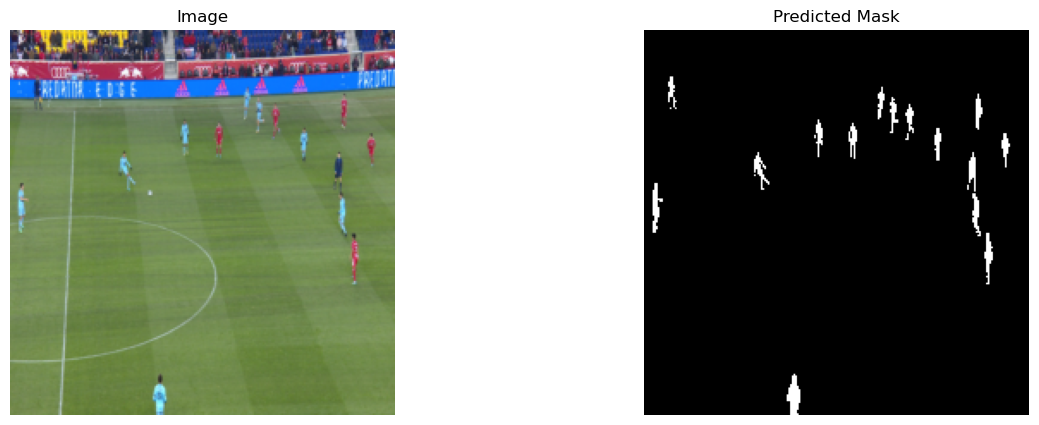

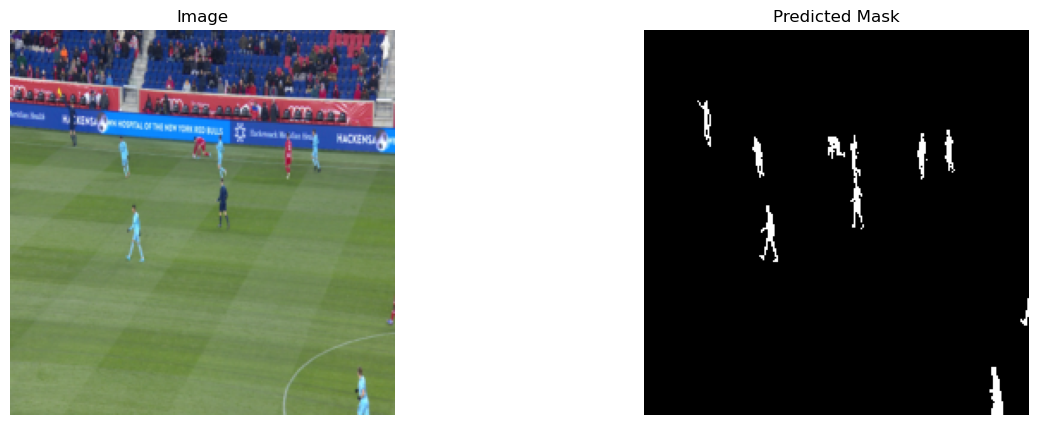

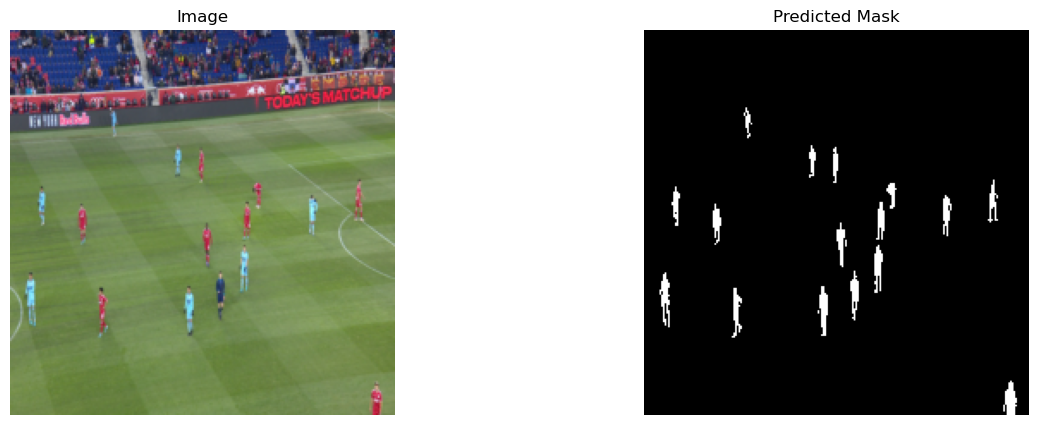

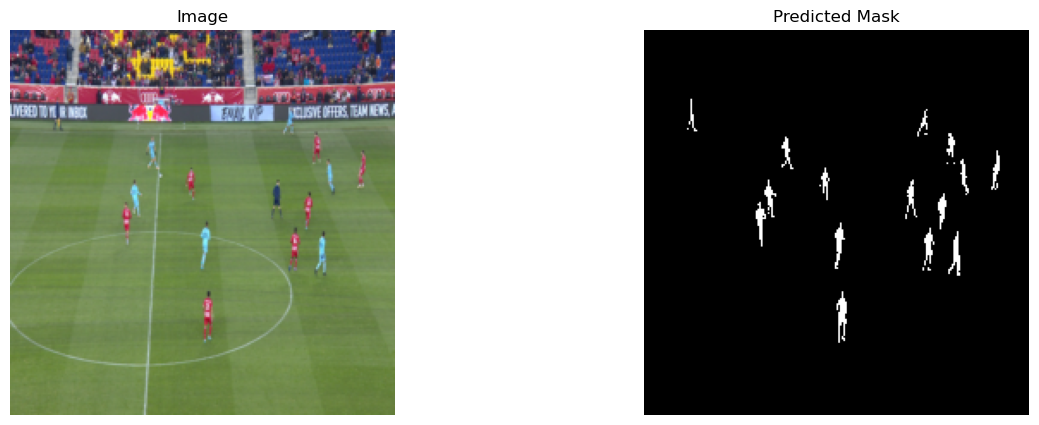

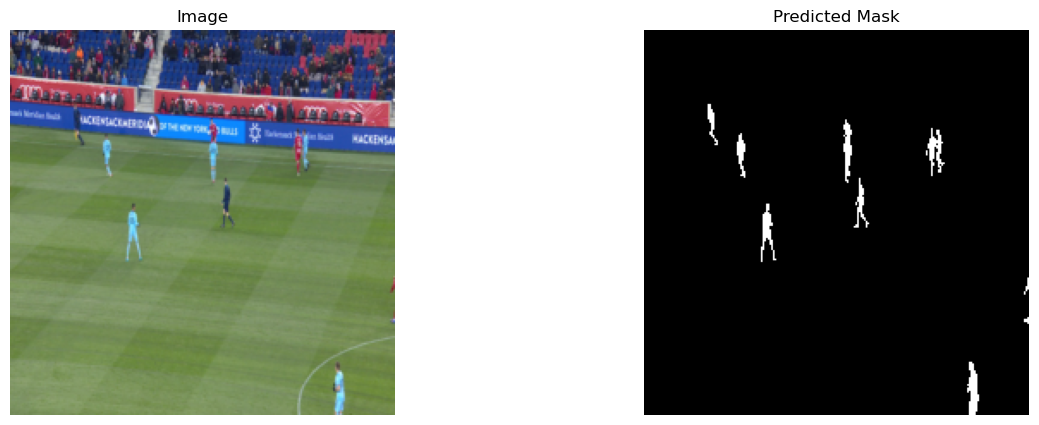

In [31]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
from torchvision import transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt  # Import matplotlib for visualization
from dataset import SegmentationDataset  # Import your dataset class
import os

# Binary Cross-Entropy Loss
bce_loss = nn.BCEWithLogitsLoss()

# Dice Loss Function
def dice_loss(pred, target, smooth=1e-5):
    pred = torch.sigmoid(pred)  # Convert logits to probabilities
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

# Combined BCE + Dice Loss
def combined_loss(pred, target):
    return bce_loss(pred, target) + dice_loss(pred, target)

def visualize_results(images, masks, outputs, num_images=5):
    num_available = min(len(images), num_images)  # Ensure we don't exceed available images

    # Convert tensors to numpy arrays for visualization
    images = images[:num_available].cpu().numpy().transpose(0, 2, 3, 1)
    masks = masks[:num_available].cpu().numpy()
    outputs = outputs[:num_available].detach().cpu().numpy()  # **Fix: detach before numpy()**

    for i in range(num_available):  # Loop only over available images
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        axes[0].imshow(images[i])
        axes[0].set_title("Image")
        axes[0].axis("off")

        axes[2].imshow(outputs[i].squeeze(), cmap='gray')

        axes[2].set_title("Predicted Mask")
        axes[2].axis("off")

        plt.show()


# Training Function
def train_model(model, train_loader, optimizer, checkpoint_path, num_epochs=10, device="cpu"):
    model = model.to(device)  # Keep model on CPU
    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=True)

        for images, masks in loop:
            images, masks = images.to(device), masks.to(device)  # Keep data on CPU
            masks = masks.squeeze(1)  # Remove extra singleton dimensions if needed
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Resize outputs to match mask size
            outputs = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear', align_corners=True)

            # Compute loss
            loss = combined_loss(outputs, masks)

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Avg Loss: {avg_loss:.4f}")

        # Save checkpoint after each epoch
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, checkpoint_path)
        print(f"Checkpoint saved at {checkpoint_path}")
    
    return model

# Evaluation Function
def evaluate_model(model, test_loader, device="cpu"):
    model.eval()
    iou_scores, dice_scores, pixel_accuracies = [], [], []

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)  # Keep data on CPU
            outputs = model(images)
            outputs = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear', align_corners=True)
            iou_scores.append(iou_score(outputs, masks))
            dice_scores.append(dice_score(outputs, masks))
            pixel_accuracies.append(pixel_accuracy(outputs, masks))

    print(f"Test IoU: {sum(iou_scores)/len(iou_scores):.4f}, Dice: {sum(dice_scores)/len(dice_scores):.4f}, Pixel Acc: {sum(pixel_accuracies)/len(pixel_accuracies):.4f}")

def main():
    print("Using device: CPU")
    
    # Set the device to CPU
    device = torch.device('cpu')

    images_dir = r"C:\\Users\\Intern\\Downloads\\extracted_images\\images"
    masks_file = "masks.npy"
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
    ])
    
    input_channels = 3
    image_size = 224
    u2net_model = build_u2net((input_channels, image_size, image_size))  # Define model
    
    # Move model to CPU
    u2net_model.to(device)

    dataset = SegmentationDataset(images_dir=images_dir, masks_file=masks_file, transform=transform)
    
    # Convert dataset into separate lists of images and masks
    images = []
    masks = []

    for img, mask in dataset:
        images.append(img.numpy())  # Convert to NumPy
        masks.append(mask.numpy())

    images = np.array(images)
    masks = np.array(masks)
    # Perform train-test split (95% train, 5% test)
    images_train, images_test, masks_train, masks_test = train_test_split(
        images, masks, test_size=0.05, random_state=42
    )

    # Convert back to PyTorch tensors
    images_train = torch.tensor(images_train, dtype=torch.float32)
    images_test = torch.tensor(images_test, dtype=torch.float32)
    masks_train = torch.tensor(masks_train, dtype=torch.float32)
    masks_test = torch.tensor(masks_test, dtype=torch.float32)


    # Create PyTorch dataset objects
    train_dataset = torch.utils.data.TensorDataset(images_train, masks_train)
    test_dataset = torch.utils.data.TensorDataset(images_test, masks_test)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=6, shuffle=False, num_workers=0)
    
    # Load checkpoint if exists
    checkpoint_path = 'u2net_checkpoint.pth'
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        u2net_model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Model is already fully trained. Skipping training step.")
        trained_model = u2net_model  # ✅ Assign trained_model to avoid error

    

    # Train Model
    num_epochs = 1  # Adjust as needed
    if start_epoch < num_epochs:
        trained_model = train_model(
            u2net_model, train_loader, optimizer, checkpoint_path, 
            num_epochs=(num_epochs - start_epoch), device=device
        )
        torch.save(trained_model.state_dict(), "u2net_final.pth")
        print("Training complete. Model saved as u2net_final.pth.")
    else:
        print("Model is already fully trained. Skipping training step.")
    
    # Save Final Model
    torch.save(trained_model.state_dict(), "u2net_final.pth")
    print("Training complete. Model saved as u2net_final.pth.")

    # Evaluate Model
    evaluate_model(trained_model, test_loader, device=device)
    
    # **Show results for a few test images**
    test_images, test_masks = next(iter(test_loader))  # Get a batch of test images
    test_outputs = trained_model(test_images.to(device))  # Generate predictions
    test_outputs = torch.sigmoid(test_outputs)  # Convert logits to probabilities

    visualize_results(test_images, test_masks, test_outputs)  # Call visualization function

if __name__ == '__main__':
    main()
